# Building Visual Agents for GUI Automation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/harpreetsahota204/odsc_workshop_visual_agents/blob/main/gui_agents_workshop.ipynb)

In this workshop, we'll explore how to build and evaluate visual agents that can interact with graphical user interfaces. We'll cover the full pipeline from data preparation to model evaluation and identifying samples for fine-tuning.

## What We'll Cover

1. **Tour of FiftyOne** - Understanding the tool we'll use for dataset curation and visualization

2. **Loading GUI Data** - Importing GUI interaction datasets using the COCO4GUI format

3. **Dataset Analysis** - Exploring the composition of our dataset (action types, annotations, etc.)

4. **Computing Embeddings** - Using Jina v4 to generate embeddings for images and UI element patches

5. **Running GUI-Actor Inference** - Applying Microsoft's GUI-Actor model to predict interaction points

6. **Evaluating Model Performance** - Measuring accuracy with standard metrics and normalized click distance

7. **Investigating Failures** - Analyzing where the model struggles using attention maps and error patterns

8. **Tagging for Fine-Tuning** - Prioritizing samples based on error type (attention misaligned vs. localization errors)

9. **Generating Synthetic Data** - Using FiftyOne plugins to augment task descriptions for training

By the end, you'll have a systematic workflow for curating high-quality training data to improve GUI agent performance.

## Prerequisites & Installation

In [ ]:
!pip install -q fiftyone gdown sentence-transformers qwen-vl-utils 'transformers<5.0' umap-learn accelerate

---
## Tour of the FiftyOne App

Before we dive into training models for GUI automation, let's understand what we're trying to teach a model to do.

We'll load FiftyOne's quickstart dataset and explore the app to understand:
- How to navigate the interface
- What kinds of interactions we want to automate (clicks, selections, etc.)
- The visual elements that make up a typical data curation workflow

[FiftyOne](https://docs.voxel51.com/) is an open-source toolkit for building high-quality datasets and computer vision models. The [`load_zoo_dataset()`](https://docs.voxel51.com/user_guide/dataset_zoo/index.html) function loads pre-configured datasets, and [`launch_app()`](https://docs.voxel51.com/user_guide/app.html) opens the interactive visualization interface.


In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

# Load the quickstart dataset
quickstart = foz.load_zoo_dataset("quickstart")

# Launch the FiftyOne App
session = fo.launch_app(quickstart, auto=False)
session.url

In [ ]:
# Close the quickstart session when done
session.close()

---
## Creating a GUI Dataset

To train a GUI agent, we need labeled data of interface interactions. 

I created a dataset using the [GUI Dataset Creator](https://github.com/harpreetsahota204/gui_dataset_creator) tool,
which allows you to:
- Capture screenshots of any application
- Annotate bounding boxes around UI elements
- Mark click points for interactions
- Add task descriptions and metadata
- Export in COCO4GUI format

**[LIVE DEMO]** Let me show you the tool and how the dataset was created.

---
## Loading the GUI Dataset

Let's download and explore the GUI interaction dataset I created.

In [ ]:
import gdown
import zipfile
import os

# Download the dataset from Google Drive
url = "https://drive.google.com/uc?id=1YEhdlXuTV_nalVvKuXSHZa_JgkuIXjcG"
output_path = "gui_data.zip"

if not os.path.exists("gui_data"):
    gdown.download(url, output_path, quiet=False)
    
    # Extract the contents
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall("gui_data")
    
    # Clean up zip file
    os.remove(output_path)
    
print("Dataset downloaded and extracted!")

### Exploring the Data Format

Let's look at an example image and its corresponding annotation structure.

In [1]:
import json
from PIL import Image
import random

# Load the annotations
annotations_path = "./gui_data/data/annotations_coco.json"
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Print basic info about the dataset
print(f"Keys in the annotations file: {list(annotations.keys())}")
print(f"Number of images: {len(annotations['images'])}")
print(f"Number of annotations: {len(annotations['annotations'])}")
print(f"Categories: {[cat['name'] for cat in annotations['categories']]}")

Keys in the annotations file: ['info', 'licenses', 'categories', 'images', 'annotations']
Number of images: 739
Number of annotations: 3567
Categories: ['click', 'type', 'select', 'hover', 'drag', 'right_click', 'double_click']


Selected image: 2025-07-30_20-43-39.png
Image size: 2506 x 1260
Number of annotations: 7


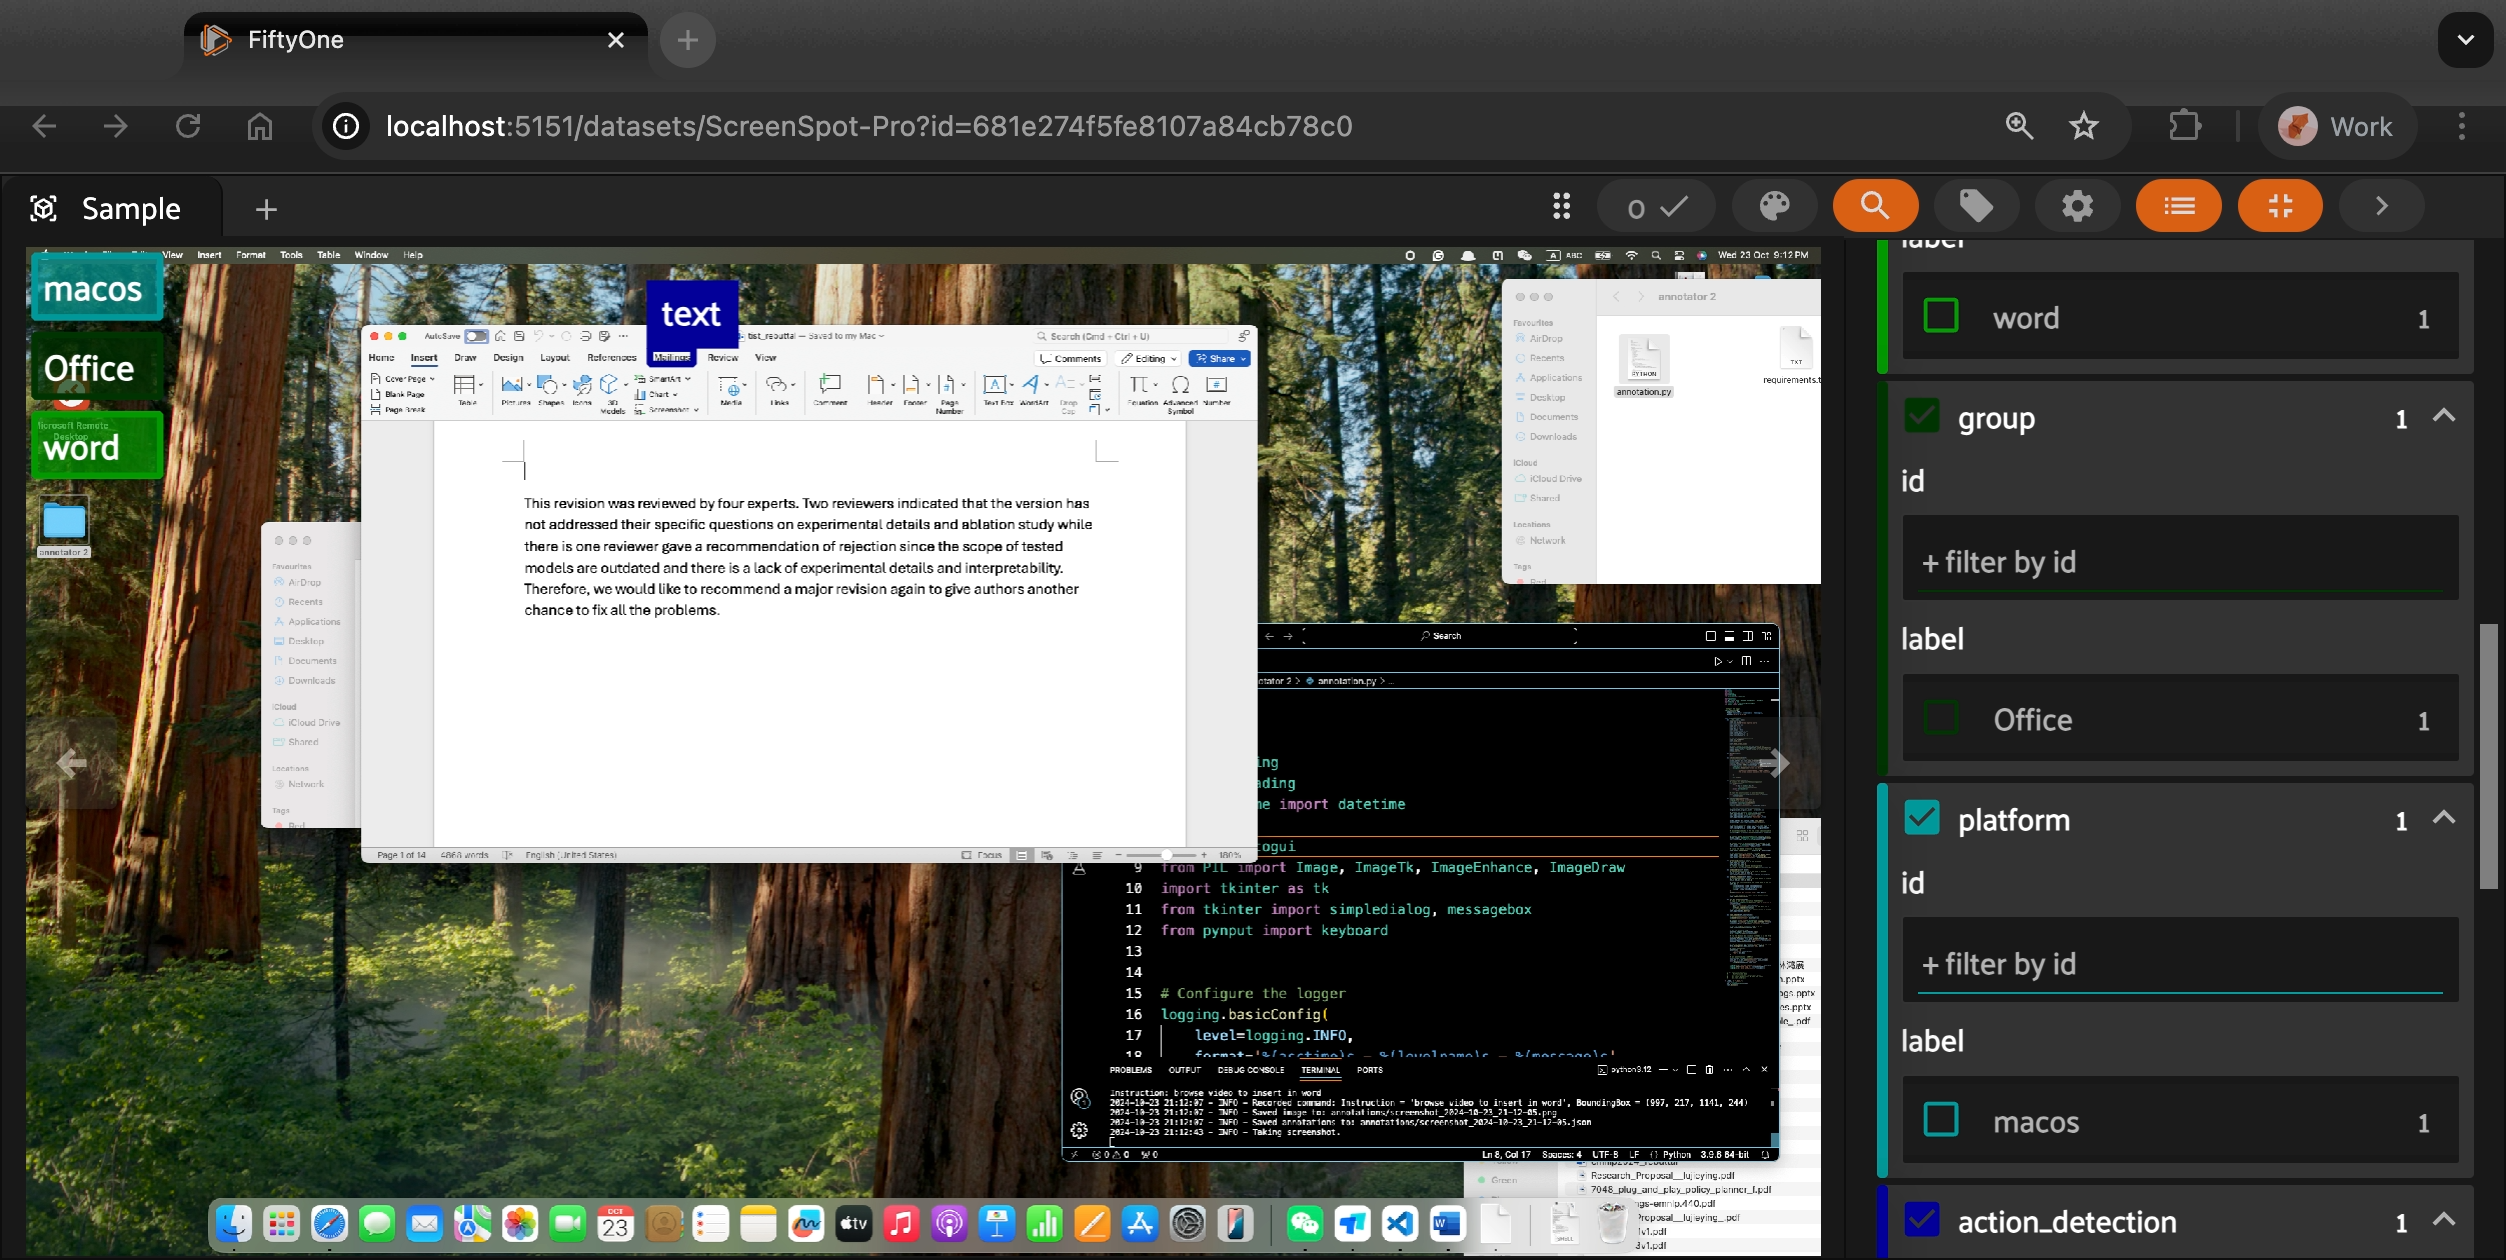

In [2]:
# Select a random image to display
random_image = random.choice(annotations['images'])
image_id = random_image['id']

# Get annotations for this image
image_annotations = [a for a in annotations['annotations'] if a['image_id'] == image_id]

print(f"Selected image: {random_image['file_name']}")
print(f"Image size: {random_image['width']} x {random_image['height']}")
print(f"Number of annotations: {len(image_annotations)}")

# Display the image
Image.open(f"./gui_data/data/{random_image['file_name']}")

In [3]:
# Show the JSON structure of an annotation
from pprint import pprint

if image_annotations:
    print("Example annotation structure:")
    pprint(image_annotations[0])

Example annotation structure:
{'area': 0,
 'attributes': {'action_type': 'click',
                'custom_metadata': {},
                'element_info': 'Icon',
                'previous_action_type': None,
                'previous_annotation_id': None,
                'previous_element_type': None,
                'previous_step_position': None,
                'steps_since_start': 1,
                'task_description': 'Hide the sidebar from the modal'},
 'category_id': 1,
 'id': 2668,
 'image_id': 191,
 'iscrowd': 0,
 'keypoints': [2382.9375, 208.28442859819052, 2]}


### Understanding COCO4GUI Format

The COCO4GUI format extends standard COCO with GUI-specific fields:

| Field | Description |
|-------|-------------|
| `bbox` | Bounding box `[x, y, width, height]` in pixels |
| `keypoints` | Click point `[x, y, visibility]` |
| `attributes.task_description` | Natural language description of the action |
| `attributes.action_type` | Type of interaction (click, type, hover, etc.) |
| `attributes.element_info` | CSS selector or element identifier |
| `attributes.custom_metadata` | Additional key-value pairs |

---
## Importing into FiftyOne with COCO4GUI

[FiftyOne](https://voxel51.com/fiftyone/) is a powerful tool for visualizing, exploring and analyzing image datasets. We'll use a specialized COCO4GUI format to load our GUI interaction dataset into FiftyOne.

The [COCO4GUI](https://github.com/harpreetsahota204/coco4gui_fiftyone) format extends the standard COCO detection format to handle GUI-specific features:

| Feature | Description |
|---------|-------------|
| **Keypoints** | Click/interaction points as `[x, y]` coordinates |
| **Task Descriptions** | Natural language descriptions of each interaction |
| **UI Metadata** | Application name, platform, and action types |

FiftyOne supports [custom dataset importers](https://docs.voxel51.com/user_guide/dataset_creation/datasets.html#custom-formats), which is what we're using here to handle the GUI-specific annotation fields.


In [ ]:
# Download the COCO4GUI importer
import urllib.request

coco4gui_url = "https://raw.githubusercontent.com/harpreetsahota204/coco4gui_fiftyone/main/coco4gui.py"
urllib.request.urlretrieve(coco4gui_url, "coco4gui.py")

In [4]:
import os
import fiftyone as fo
from coco4gui import COCO4GUIDataset

# Define paths to our dataset
dataset_dir = os.getcwd()
data_path = "gui_data/data"
labels_path = "gui_data/data/annotations_coco.json"

# Create the dataset
gui_dataset = fo.Dataset.from_dir(
    dataset_dir=dataset_dir,
    dataset_type=COCO4GUIDataset,
    name="gui_workshop_dataset",
    data_path=data_path,
    labels_path=labels_path,
    overwrite=True,
    persistent=True,
    include_gui_metadata=True,
    extra_attrs=True,
)

print(gui_dataset)

 100% |█████████████████| 739/739 [2.4s elapsed, 0s remaining, 306.0 samples/s]      
Name:        gui_workshop_dataset
Media type:  image
Num samples: 739
Persistent:  True
Tags:        []
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:        fiftyone.core.fields.DateTimeField
    last_modified_at:  fiftyone.core.fields.DateTimeField
    keypoints:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Keypoints)
    application:       fiftyone.core.fields.StringField
    platform:          fiftyone.core.fields.StringField
    detections:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    steps_since_start: fiftyone.core.fields.IntField


### Exploring a FiftyOne Sample

Let's see what a sample looks like after importing into FiftyOne.

In [5]:
# Get a sample with annotations
sample = gui_dataset.first()
sample

<Sample: {
    'id': '697b7d67f548ad03b47080cc',
    'media_type': 'image',
    'filepath': '/home/harpreet/workspace/odsc_workshop_visual_agents/gui_data/data/2025-07-22_18-23-08.png',
    'tags': [],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 2992,
        'height': 1866,
        'num_channels': None,
    }>,
    'created_at': datetime.datetime(2026, 1, 29, 15, 31, 51, 807000),
    'last_modified_at': datetime.datetime(2026, 1, 29, 15, 31, 51, 807000),
    'keypoints': <Keypoints: {
        'keypoints': [
            <Keypoint: {
                'id': '697b7d67f548ad03b47080b9',
                'attributes': {},
                'tags': [],
                'label': 'click',
                'points': [[0.5, 0.28627170617420067]],
                'confidence': None,
                'index': None,
                'visible': [2],
                'supercategory': 'interaction',
                'iscrowd': 0,
                'tas

The code above uses [`match()`](https://docs.voxel51.com/user_guide/using_views.html#matching) with a [`ViewField`](https://docs.voxel51.com/user_guide/using_views.html#view-expressions) expression to find samples where detections exist. The `first()` method returns the first sample from the filtered view.

Each FiftyOne [Sample](https://docs.voxel51.com/user_guide/using_datasets.html#samples) contains:
- `filepath`: Path to the image file
- `tags`: List of tags for organizing samples
- `metadata`: Image dimensions and other metadata
- Custom fields like `detections`, `keypoints`, `application`, `platform`


In [6]:
example_kp = sample.keypoints.keypoints[0]
print(f"Label: {example_kp.label}")
print(f"Point: {example_kp.points}")
print(f"Task description: {example_kp.task_description}")
print(f"Action type: {example_kp.action_type}")

Label: click
Point: [[0.5, 0.28627170617420067]]
Task description: Open color settings
Action type: click


---
## Dataset Analysis

Let's analyze our GUI dataset to understand its composition and characteristics.

FiftyOne provides powerful aggregation methods for dataset analysis:
- [`ViewField` (F)](https://docs.voxel51.com/user_guide/using_views.html#view-expressions): Create expressions to access nested fields
- [`values()`](https://docs.voxel51.com/user_guide/using_aggregations.html#values): Extract field values across all samples
- [`set_values()`](https://docs.voxel51.com/user_guide/using_datasets.html#batch-updates): Batch update field values
- [`count_values()`](https://docs.voxel51.com/user_guide/using_aggregations.html#count-values): Count occurrences of each unique value


In [7]:
from fiftyone import ViewField as F

# Count UI elements per sample
box_counts = gui_dataset.values(F("detections.detections").length())
gui_dataset.set_values("box_counts", box_counts)

# Count keypoints per sample
point_counts = gui_dataset.values(F("keypoints.keypoints").length())
gui_dataset.set_values("point_counts", point_counts)

print(f"Total samples: {len(gui_dataset)}")
print(f"Average UI elements per sample: {sum(box_counts) / len(box_counts):.2f}")
print(f"Average keypoints per sample: {sum(point_counts) / len(point_counts):.2f}")

Total samples: 739
Average UI elements per sample: 1.58
Average keypoints per sample: 3.24


In [8]:
gui_dataset.count_values("detections.detections.label")

{'select': 111, 'click': 468, 'type': 3, 'hover': 570, 'drag': 18}

In [9]:
gui_dataset.count_values("keypoints.keypoints.label")

{'select': 158, 'click': 1960, 'type': 48, 'hover': 185, 'drag': 46}

In [10]:
# Create views for different annotation states
from fiftyone import ViewField as F

# Samples with missing task descriptions
no_det_task_desc = gui_dataset.filter_labels(
    "detections", 
    F("task_description") == "", 
    only_matches=True
)

gui_dataset.save_view("no_det_task_desc", no_det_task_desc)

print(f"Samples with missing detection task descriptions: {len(no_det_task_desc)}")


Samples with missing detection task descriptions: 13


The [`filter_labels()`](https://docs.voxel51.com/user_guide/using_views.html#filtering-sample-contents) method filters individual labels within samples based on expressions. Combined with [`save_view()`](https://docs.voxel51.com/user_guide/using_views.html#saving-views), you can create named views for easy access later.


In [11]:

# Samples with click interactions only
clicks_only = gui_dataset.filter_labels("detections", F("label") == "click")
gui_dataset.save_view("clicks_only", clicks_only)

print(f"Samples with clicks only: {len(clicks_only)}")

Samples with clicks only: 228


---
## Computing Embeddings with Jina v4

We'll use Jina Embeddings v4, a powerful multimodal model, to compute embeddings for both full images and UI element patches.

FiftyOne's [model zoo](https://docs.voxel51.com/user_guide/model_zoo/index.html) supports custom model sources. You can register external repositories containing model implementations using [`register_zoo_model_source()`](https://docs.voxel51.com/api/fiftyone.zoo.models.html#fiftyone.zoo.models.register_zoo_model_source).


In [ ]:
import fiftyone.zoo as foz

import fiftyone.zoo as foz

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Register this repository as a remote zoo model source
foz.register_zoo_model_source(
    "https://github.com/harpreetsahota204/jina_embeddings_v4",
    overwrite=True 
)

jina_model = foz.load_zoo_model(
    "jinaai/jina-embeddings-v4",
    task="retrieval",  # or "text-matching", "code", but for visualzing embeddings this is best
)


### Embeddings for Full Images

The [`compute_embeddings()`](https://docs.voxel51.com/user_guide/brain.html#image-embeddings) method generates embeddings for entire images and stores them in the specified field.


In [13]:
# Compute embeddings for the full GUI dataset
gui_dataset.compute_embeddings(
    model=jina_model,
    embeddings_field="jina_embeddings",
)

print(f"Embedding shape: {gui_dataset.first()['jina_embeddings'].shape}")

 100% |█████████████████| 739/739 [2.9m elapsed, 0s remaining, 4.3 samples/s]      
Embedding shape: (2048,)


[`compute_visualization()`](https://docs.voxel51.com/user_guide/brain.html#visualizing-embeddings) projects embeddings to 2D/3D for interactive exploration. [`compute_similarity()`](https://docs.voxel51.com/user_guide/brain.html#similarity) creates a similarity index for finding similar samples.


In [14]:
import fiftyone.brain as fob

# Compute UMAP visualization
fob.compute_visualization(
    gui_dataset,
    embeddings="jina_embeddings",
    method="umap",
    brain_key="whole_viz"
)

# Compute similarity index
fob.compute_similarity(
    gui_dataset,
    backend="sklearn",
    brain_key="whole_sim",
    embeddings="jina_embeddings"
)

Generating visualization...
UMAP( verbose=True)
Thu Jan 29 09:36:18 2026 Construct fuzzy simplicial set
Thu Jan 29 09:36:18 2026 Finding Nearest Neighbors
Thu Jan 29 09:36:21 2026 Finished Nearest Neighbor Search
Thu Jan 29 09:36:24 2026 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jan 29 09:36:28 2026 Finished embedding


### Embeddings for UI Element Patches

The [`compute_patch_embeddings()`](https://docs.voxel51.com/user_guide/brain.html#patch-embeddings) method computes embeddings for individual objects (patches) defined by a detection field, enabling fine-grained similarity search on UI elements.


In [ ]:


# Compute embeddings for object patches in the `ground_truth` field
gui_dataset.compute_patch_embeddings(
    jina_model,
    patches_field="detections",   # Detections/Polylines field defining patches
    embeddings_field="patch_embeddings",  # label attribute to store embeddings
    skip_failures=False
)

# Compute visualization for patches
fob.compute_visualization(
    gui_dataset,
    embeddings="patch_embeddings",
    method="umap",
    brain_key="patch_viz"
)

# Compute similarity for patches
fob.compute_similarity(
    gui_dataset,
    backend="sklearn",
    brain_key="patch_sim",
    embeddings="patch_embeddings"
)

---
## Exploring the GUI Dataset in the App

Let's launch the FiftyOne App to explore our GUI dataset interactively.
We'll perform similar analysis as we did with the quickstart dataset.

In [ ]:
session = fo.launch_app(gui_dataset)

**[LIVE DEMO]**

In the app, we'll:
1. Explore the embeddings visualization to find clusters of similar UI elements
2. Use similarity search to find related screenshots
3. Filter by action types and other metadata
4. Create dashboards to analyze the dataset

---
## Working with Only Keypoints

For GUI agents, we often want to predict click points rather than bounding boxes. Besides, GUI-Actor (which we will use later) only outputs keypoints. So, let's work with a keypoint-focused view.

The [`to_patches()`](https://docs.voxel51.com/user_guide/using_views.html#object-patches) method creates a view where each sample corresponds to a single object (in this case, keypoint). The [`clone()`](https://docs.voxel51.com/user_guide/using_datasets.html#cloning-datasets) method creates a new persistent dataset from the view.


In [ ]:
# Create a patches view from keypoints
kp_patches = gui_dataset.to_patches("keypoints", keep_label_lists=True)
kp_patches = kp_patches.clone()
kp_patches.persistent=True
kp_patches.name="keypoint_patches"
print(f"Created {len(kp_patches)} patches from {len(gui_dataset)} samples")

Created 2397 patches from 739 samples


We'll bring the task description to a top level sample field, which makes inference with FiftyOne easier.

Using [`values()`](https://docs.voxel51.com/user_guide/using_aggregations.html#values) we extract nested field values, and [`set_values()`](https://docs.voxel51.com/user_guide/using_datasets.html#batch-updates) efficiently updates all samples in a single operation.


In [17]:
# 1) Extract the nested values
values = kp_patches.values("keypoints.keypoints.task_description")

# 2) Set them as a top-level field in one batch
kp_patches.set_values("task_description", values)

In [18]:
kp_patches.first()

<Sample: {
    'id': '697b7d67f548ad03b47080b9',
    'media_type': 'image',
    'filepath': '/home/harpreet/workspace/odsc_workshop_visual_agents/gui_data/data/2025-07-22_18-23-08.png',
    'tags': [],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 2992,
        'height': 1866,
        'num_channels': None,
    }>,
    'created_at': datetime.datetime(2026, 1, 29, 15, 40, 20, 436000),
    'last_modified_at': datetime.datetime(2026, 1, 29, 15, 40, 20, 552000),
    'sample_id': '697b7d67f548ad03b47080cc',
    'keypoints': <Keypoints: {
        'keypoints': [
            <Keypoint: {
                'id': '697b7d67f548ad03b47080b9',
                'attributes': {},
                'tags': [],
                'label': 'click',
                'points': [[0.5, 0.28627170617420067]],
                'confidence': None,
                'index': None,
                'visible': [2],
                'supercategory': 'interaction',
     

---
## Running GUI Actor Inference

Now let's use Microsoft's GUI-Actor model to predict interaction points and compare with our ground truth.

FiftyOne's [`apply_model()`](https://docs.voxel51.com/user_guide/using_models.html#applying-models) method runs inference on all samples, storing predictions in the specified field. The `prompt_field` parameter allows you to use a dataset field as input to prompt-based models.


In [ ]:
import fiftyone.zoo as foz

# # Register the GUI Actor model source
foz.register_zoo_model_source(
    "https://github.com/harpreetsahota204/gui_actor",
    overwrite=True
)

# Load the GUI-Actor model (3B version for faster inference)
gui_actor = foz.load_zoo_model(
    "microsoft/GUI-Actor-3B-Qwen2.5-VL",
)

In [20]:
# Apply model to predict interaction points
# Using task_description as the prompt field
kp_patches.apply_model(
    gui_actor,
    prompt_field="task_description",
    label_field="predicted_keypoints",
    skip_failures=False
)

 100% |███████████████| 2397/2397 [43.9m elapsed, 0s remaining, 1.2 samples/s]      


---
## Evaluating Model Performance

Let's evaluate how well GUI-Actor predicts interaction points compared to our ground truth.

FiftyOne's [`evaluate_detections()`](https://docs.voxel51.com/user_guide/evaluation.html#detections) method computes standard metrics (precision, recall, mAP) and adds per-sample evaluation fields (`_tp`, `_fp`, `_fn`) for detailed analysis.


In [1]:
import fiftyone as fo
kp_patches = fo.load_dataset("keypoint_patches")

In [18]:
# Evaluate keypoint predictions
results = kp_patches.evaluate_detections(
    "predicted_keypoints",
    gt_field="keypoints",
    eval_key="kp_eval",
    iou=0.002,
    classwise=False,  # Ignore class labels when matching
)

# Print evaluation report
results.print_report()

Evaluating detections...
   3% |/--------------|   61/2397 [104.7ms elapsed, 4.0s remaining, 582.7 samples/s] 

/home/harpreet/miniconda3/envs/fiftyone/lib/python3.11/site-packages/fiftyone/utils/iou.py:1035: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.exp(-(dists**2) / (2 * (scale**2)))) / n


 100% |███████████████| 2397/2397 [4.4s elapsed, 0s remaining, 572.6 samples/s]       
                       precision    recall  f1-score   support

                click       0.00      0.00      0.00    1960.0
                 drag       0.00      0.00      0.00      46.0
                hover       0.00      0.00      0.00     185.0
               select       0.00      0.00      0.00     158.0
top_interaction_point       0.00      0.00      0.00       0.0
                 type       0.00      0.00      0.00      48.0

            micro avg       0.00      0.00      0.00    2397.0
            macro avg       0.00      0.00      0.00    2397.0
         weighted avg       0.00      0.00      0.00    2397.0



---
## Investigating Model Failures

Let's analyze where the model struggles most to understand its limitations.

After evaluation, FiftyOne adds per-sample metrics that you can use with [`match()`](https://docs.voxel51.com/user_guide/using_views.html#matching) to find problematic samples. The [`tag_samples()`](https://docs.voxel51.com/user_guide/using_datasets.html#tags) method lets you mark samples for later retrieval.


In [4]:
from fiftyone import ViewField as F

# Find samples where the model missed the ground truth (false negative)
missed_points = kp_patches.match(F("kp_eval_fn") == 1)
kp_patches.save_view("missed_points", missed_points)
print(f"Samples with missed detections: {len(missed_points)}")

# Find samples where the model predicted incorrectly (false positive)
incorrect_predictions = kp_patches.match(F("kp_eval_fp") == 1)
kp_patches.save_view("incorrect_predictions", incorrect_predictions)
print(f"Samples with incorrect predictions: {len(incorrect_predictions)}")

Samples with missed detections: 2397
Samples with incorrect predictions: 2397


In [5]:
from fiftyone import ViewField as F
# Analyze failures by action type
# On a patches view, each sample has one keypoint

# Create a view for each missed label type
missed_labels = missed_points.distinct("keypoints.label")

for label in missed_labels:
    label_view = missed_points.match(F("keypoints.label") == label)
    view_name = f"missed_{label}"
    kp_patches.save_view(view_name, label_view)
    print(f"Saved view '{view_name}' with {len(label_view)} samples")

In [6]:
from fiftyone import ViewField as F
# Create a view for each incorrect prediction label type
incorrect_labels = incorrect_predictions.distinct("keypoints.label")

for label in incorrect_labels:
    label_view = incorrect_predictions.match(F("keypoints.label") == label)
    view_name = f"incorrect_{label}"
    kp_patches.save_view(view_name, label_view)
    print(f"Saved view '{view_name}' with {len(label_view)} samples")

In [7]:
from fiftyone import ViewField as F
# Tag problematic samples for review (any missed or incorrect prediction)
high_error_view = kp_patches.match(
    (F("kp_eval_fn") == 1) | (F("kp_eval_fp") == 1)
)
high_error_view.tag_samples("needs_review")

print(f"Tagged {len(high_error_view)} samples for review")

Tagged 2397 samples for review


### Visualizing Failures

In [ ]:
# Launch app to investigate failures
session = fo.launch_app(high_error_view)

### Checking if Keypoints Fall Within Attention Regions

Keypoints in FiftyOne use **normalized coordinates** (0 to 1), while attention maps are **pixel arrays** with shape `(H, W)`. To check if a keypoint falls within a high-attention region:

1. Convert normalized coordinates → pixel indices
2. Sample the **neighborhood** around each keypoint (not just the exact pixel, since attention maps are low-resolution and FiftyOne upscales them for display)
3. Compare against a **percentile threshold** to define "high attention" (attention maps rarely have true zeros)

Use this to explore and understand what's happening at each keypoint location.

In [8]:
import numpy as np

def get_max_attention_in_neighborhood(attention_map, py, px, radius=2):
    """
    Find the maximum attention value within a window around each keypoint.
    
    Since attention maps are low-resolution (e.g., 67x107) compared to the original
    image, checking a neighborhood compensates for quantization error when mapping
    normalized coordinates to pixel indices.
    
    Args:
        attention_map: 2D numpy array of shape (H, W) containing attention values
        py: Array of y pixel indices for each keypoint
        px: Array of x pixel indices for each keypoint
        radius: Half-width of the square window to check. A radius of 2 creates
                a 5x5 window. Larger values are more lenient, smaller are stricter.
    
    Returns:
        Array of max attention values, one per keypoint
    """
    h, w = attention_map.shape
    max_vals = []
    
    for y, x in zip(py, px):
        # Define window bounds, clamped to valid array indices
        y_min, y_max = max(0, y - radius), min(h, y + radius + 1)
        x_min, x_max = max(0, x - radius), min(w, x + radius + 1)
        
        neighborhood = attention_map[y_min:y_max, x_min:x_max]
        max_vals.append(neighborhood.max())
    
    return np.array(max_vals)


for sample in kp_patches:
    heatmap = sample["gui_actor_heatmap"]
    keypoints = sample["keypoints"]
    
    if heatmap is None or keypoints is None:
        continue
    
    attention_map = heatmap.map
    h, w = attention_map.shape
    
    # Collect all keypoints into Nx2 array of (x, y) normalized coords
    all_points = np.concatenate([
        np.array(kp.points) for kp in keypoints.keypoints
    ])
    
    # Convert normalized [0,1] coords to pixel indices
    px = (all_points[:, 0] * w).astype(int).clip(0, w - 1)
    py = (all_points[:, 1] * h).astype(int).clip(0, h - 1)
    
    # Check neighborhood around each keypoint (not just exact pixel)
    attention_values = get_max_attention_in_neighborhood(attention_map, py, px, radius=1)
    
    # Use percentile threshold since attention maps rarely have true zeros
    threshold = np.percentile(attention_map, 80)
    in_attention = attention_values > threshold
    
    # Store results
    sample["keypoint_in_attention"] = bool(in_attention.any())
    sample["frac_keypoints_in_attention"] = float(in_attention.mean())
    sample.save()

Use this to store results back to the dataset so you can filter/sort in the App.


In [9]:
from fiftyone import ViewField as F

# Filter to samples where keypoints overlap with attention
keypoint_in_attention_view = kp_patches.match(F("keypoint_in_attention") == True)

kp_patches.save_view("keypoint_in_attention", keypoint_in_attention_view)

**[LIVE DEMO]**

In the app, we'll:
1. Compare predicted vs ground truth keypoints
2. Look at attention heatmaps to understand model focus
3. Identify patterns in failures (small elements, complex UIs, etc.)

---
## Tagging Samples for Fine-Tuning

Based on our error analysis and attention map alignment, we'll tag samples by fine-tuning priority:

| Tag | Condition | Interpretation |
|-----|-----------|----------------|
| `high_priority` | Wrong prediction + attention off target | Model is completely lost - needs to learn where to look |
| `medium_priority` | Wrong prediction + attention on target | Model sees it but can't pinpoint - needs localization refinement |

The [`tag_samples()`](https://docs.voxel51.com/user_guide/using_datasets.html#tags) method adds tags to samples, and [`match_tags()`](https://docs.voxel51.com/user_guide/using_views.html#matching) filters by tags. Use `bool=False` to exclude tagged samples.

In [10]:
from fiftyone import ViewField as F

# HIGH PRIORITY: Model got it wrong AND wasn't even looking at the right place
high_priority = kp_patches.match(
    (F("kp_eval_fn") == 1) & (F("keypoint_in_attention") == False)
)
high_priority.tag_samples("high_priority")
print(f"HIGH PRIORITY (wrong + attention misaligned): {len(high_priority)}")

# MEDIUM PRIORITY: Model got it wrong BUT was looking at the right area
medium_priority = kp_patches.match(
    (F("kp_eval_fn") == 1) & (F("keypoint_in_attention") == True)
)
medium_priority.tag_samples("medium_priority")
print(f"MEDIUM PRIORITY (wrong + attention aligned): {len(medium_priority)}")

# Breakdown by label for high priority samples
print("\n=== HIGH PRIORITY by action type ===")
for label, count in sorted(high_priority.count_values("keypoints.label").items(), key=lambda x: -x[1]):
    print(f"  {label}: {count}")

print("\n=== MEDIUM PRIORITY by action type ===")
for label, count in sorted(medium_priority.count_values("keypoints.label").items(), key=lambda x: -x[1]):
    print(f"  {label}: {count}")

# Summary stats
total_errors = len(missed_points)
print(f"\n=== SUMMARY ===")
print(f"Total errors: {total_errors}")
print(f"  - Attention misaligned: {len(high_priority)} ({100*len(high_priority)/max(1,total_errors):.1f}%)")
print(f"  - Attention aligned but wrong: {len(medium_priority)} ({100*len(medium_priority)/max(1,total_errors):.1f}%)")

HIGH PRIORITY (wrong + attention misaligned): 46
MEDIUM PRIORITY (wrong + attention aligned): 2351

=== HIGH PRIORITY by action type ===
  None: 46

=== MEDIUM PRIORITY by action type ===
  None: 2351

=== SUMMARY ===
Total errors: 2397
  - Attention misaligned: 46 (1.9%)
  - Attention aligned but wrong: 2351 (98.1%)


---
## Generating Synthetic Samples with FiftyOne Plugins

To improve model robustness, we can generate synthetic training samples using FiftyOne plugins. The [Synthetic GUI Samples Plugin](https://github.com/harpreetsahota204/synthetic_gui_samples_plugins) provides operators for:

- **Task Description Augmentation**: Rephrase or translate task descriptions using LLMs
- **Color Transformations**: Simulate colorblindness, grayscale, inverted colors
- **Resolution Changes**: Resize images while preserving annotation coordinates

First, let's download and install the plugin.


In [11]:
# Download the Synthetic GUI Samples plugin
!fiftyone plugins download https://github.com/harpreetsahota204/synthetic_gui_samples_plugins.git --overwrite

  599.7Mb [3.2s elapsed, ? remaining, 211.3Mb/s]    
Copying plugin '@harpreetsahota/synthetic_gui_samples_plugins' to '/home/harpreet/fiftyone/__plugins__/@harpreetsahota/synthetic_gui_samples_plugins'


FiftyOne [plugins](https://docs.voxel51.com/plugins/index.html) extend functionality with custom operators. You can invoke plugin operators programmatically using [`foo.get_operator()`](https://docs.voxel51.com/plugins/developing_plugins.html#invoking-operators-via-sdk) or through the App interface.

For long-running operations, plugins support [delegated execution](https://docs.voxel51.com/plugins/developing_plugins.html#delegated-execution), which runs tasks in background workers.


### Task Description Augmentation via SDK

Let's rephrase task descriptions to create varied training data. Before running, start the delegated service in a terminal:

```bash
fiftyone delegated launch
```


In [ ]:
import os
import fiftyone.operators as foo

os.environ['FIFTYONE_ALLOW_LEGACY_ORCHESTRATORS'] = 'true'

# Get samples tagged for fine-tuning (high or medium priority)
training_samples = kp_patches.match_tags(["high_priority"])
kp_patches.save_view("training_samples", training_samples)
training_samples.clone(name="gui_actor_training_samles")
print(f"Training samples: {len(training_samples)}")

# Get the task description augmentation operator
rephraser = foo.get_operator("@harpreetsahota/synthetic_gui_samples_plugins/task_description_augment")

# Apply rephrasing to the training samples
rephraser(
    training_samples.clone(),
    model_name="Qwen/Qwen3-1.7B",
    mode="rephrase",  # or use "translate" and pass target_language
    target_language="",
    enable_thinking=False,  # Enable for better results (takes longer)
    process_keypoints=True,
    process_detections=False,
    delegate=True  # Run in background worker
)

Training samples: 46


<Task pending name='Task-15' coro=<execute_or_delegate_operator() running at /home/harpreet/miniconda3/envs/fiftyone/lib/python3.11/site-packages/fiftyone/operators/decorators.py:22>>

You can monitor delegated operations with:

```bash
fiftyone delegated list
```

**Note:** I'll demonstrate the other augmentation operators (colorblind simulation, image resizing, etc.) in the FiftyOne App during the live demo.


---
## Converting to PyTorch Dataset

Finally, let's convert our FiftyOne dataset to a PyTorch-compatible format for model training.

FiftyOne's [`to_torch()`](https://docs.voxel51.com/integrations/pytorch.html) method converts datasets to PyTorch format. By subclassing `GetItem`, you can customize exactly what data is returned for each sample during training.


In [15]:
from fiftyone.utils.torch import GetItem

class GUIDataGetter(GetItem):
    """Custom getter for GUI training data."""
    
    @property
    def required_keys(self):
        return ['filepath', 'keypoints']
    
    def __call__(self, d):
        keypoints = []
        task_descriptions = []
        
        # Extract keypoint data
        if d.get("keypoints") and hasattr(d["keypoints"], 'keypoints'):
            for kp in d["keypoints"].keypoints:
                if kp.points:
                    keypoints.append(kp.points[0])  # (x, y)
                    task_descriptions.append(
                        getattr(kp, 'task_description', '')
                    )
        
        return {
            "filepath": d.get("filepath", ""),
            "keypoints": keypoints,
            "task_descriptions": task_descriptions,
        }

In [17]:
# Create PyTorch dataset from good samples
train_view = kp_patches.match_tags("high_priority")
torch_dataset = train_view.to_torch(GUIDataGetter())

print(f"PyTorch dataset size: {len(torch_dataset)}")

PyTorch dataset size: 46


In [18]:
# Example: accessing a sample
if len(torch_dataset) > 0:
    sample = torch_dataset[0]
    print(f"Filepath: {sample['filepath']}")
    print(f"Number of keypoints: {len(sample['keypoints'])}")
    print(f"Task descriptions: {sample['task_descriptions'][:3]}...")

Filepath: /home/harpreet/workspace/odsc_workshop_visual_agents/gui_data/data/2025-07-22_19-49-32.png
Number of keypoints: 1
Task descriptions: ['Expand the modal for this image']...


And now from here, you can follow along with the fine-tuning as specified in GUI Actor Repo and run the same evalutions on your fine-tuned model as you've done here.

All you have to do is fork the repo for the remote zoo model definition and [add your checkpoint to the manifest](https://github.com/harpreetsahota204/gui_actor/blob/main/manifest.json).

---
## Summary

In this workshop, we covered the complete pipeline for building GUI visual agents:

1. **Understanding the task**: Toured the FiftyOne app to see what interactions we want to automate
2. **Data collection**: Used GUI Dataset Creator to capture and annotate screenshots
3. **Data loading**: Imported COCO4GUI format into FiftyOne
4. **Analysis**: Explored dataset characteristics and created useful views
5. **Embeddings**: Computed multimodal embeddings for similarity search
6. **Inference**: Ran GUI-Actor model to predict interaction points
7. **Evaluation**: Measured model performance against ground truth
8. **Error analysis**: Identified failure patterns for improvement
9. **Export**: Converted to PyTorch format for fine-tuning

### Next Steps

- Fine-tune GUI-Actor on your custom dataset
- Collect more data in areas where the model struggles
- Experiment with different embedding models for UI understanding
- Deploy your trained model for GUI automation tasks

In [ ]:
# Clean up
# fo.delete_dataset("gui_workshop_dataset")
# fo.delete_dataset("gui_box_patches")
# fo.delete_dataset("gui_keypoint_patches")